# Linear Regression with Polynomial Features

In [1]:
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [2]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14563.73,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14563.73,1.021,0.1276,0.2552


In [3]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


### Create data frame with important features

In [4]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [5]:
df_model = df[list_imp_feat].copy()

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

### Fill and drop NaN

In [7]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

In [8]:
df_model.dropna(inplace=True)

In [9]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180149 entries, 1 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180149 non-null  float64
 1   ME.FTS.act.dgC           180149 non-null  float64
 2   HFO.GME.act.nodim        180149 non-null  float64
 3   V.COG.act.deg            180149 non-null  float64
 4   V.SOG.act.kn             180149 non-null  float64
 5   V.RUA.act.deg            180149 non-null  float64
 6   V.GPSLAT.act.deg         180149 non-null  float64
 7   V.GPSLON.act.deg         180149 non-null  float64
 8   WEA.WDT.act.deg          180149 non-null  float64
 9   WEA.WST.act.mPs          180149 non-null  float64
 10  V.SLPOG.act.PRC          180149 non-null  float64
 11  ME.SFCI.act.gPkWh        180149 non-null  float64
 12  DDM.TRIM.act.m           180149 non-null  float64
 13  DDM.DRAFT.act.m          180149 non-null  float64
 14  pass

### Check correlations

<AxesSubplot:>

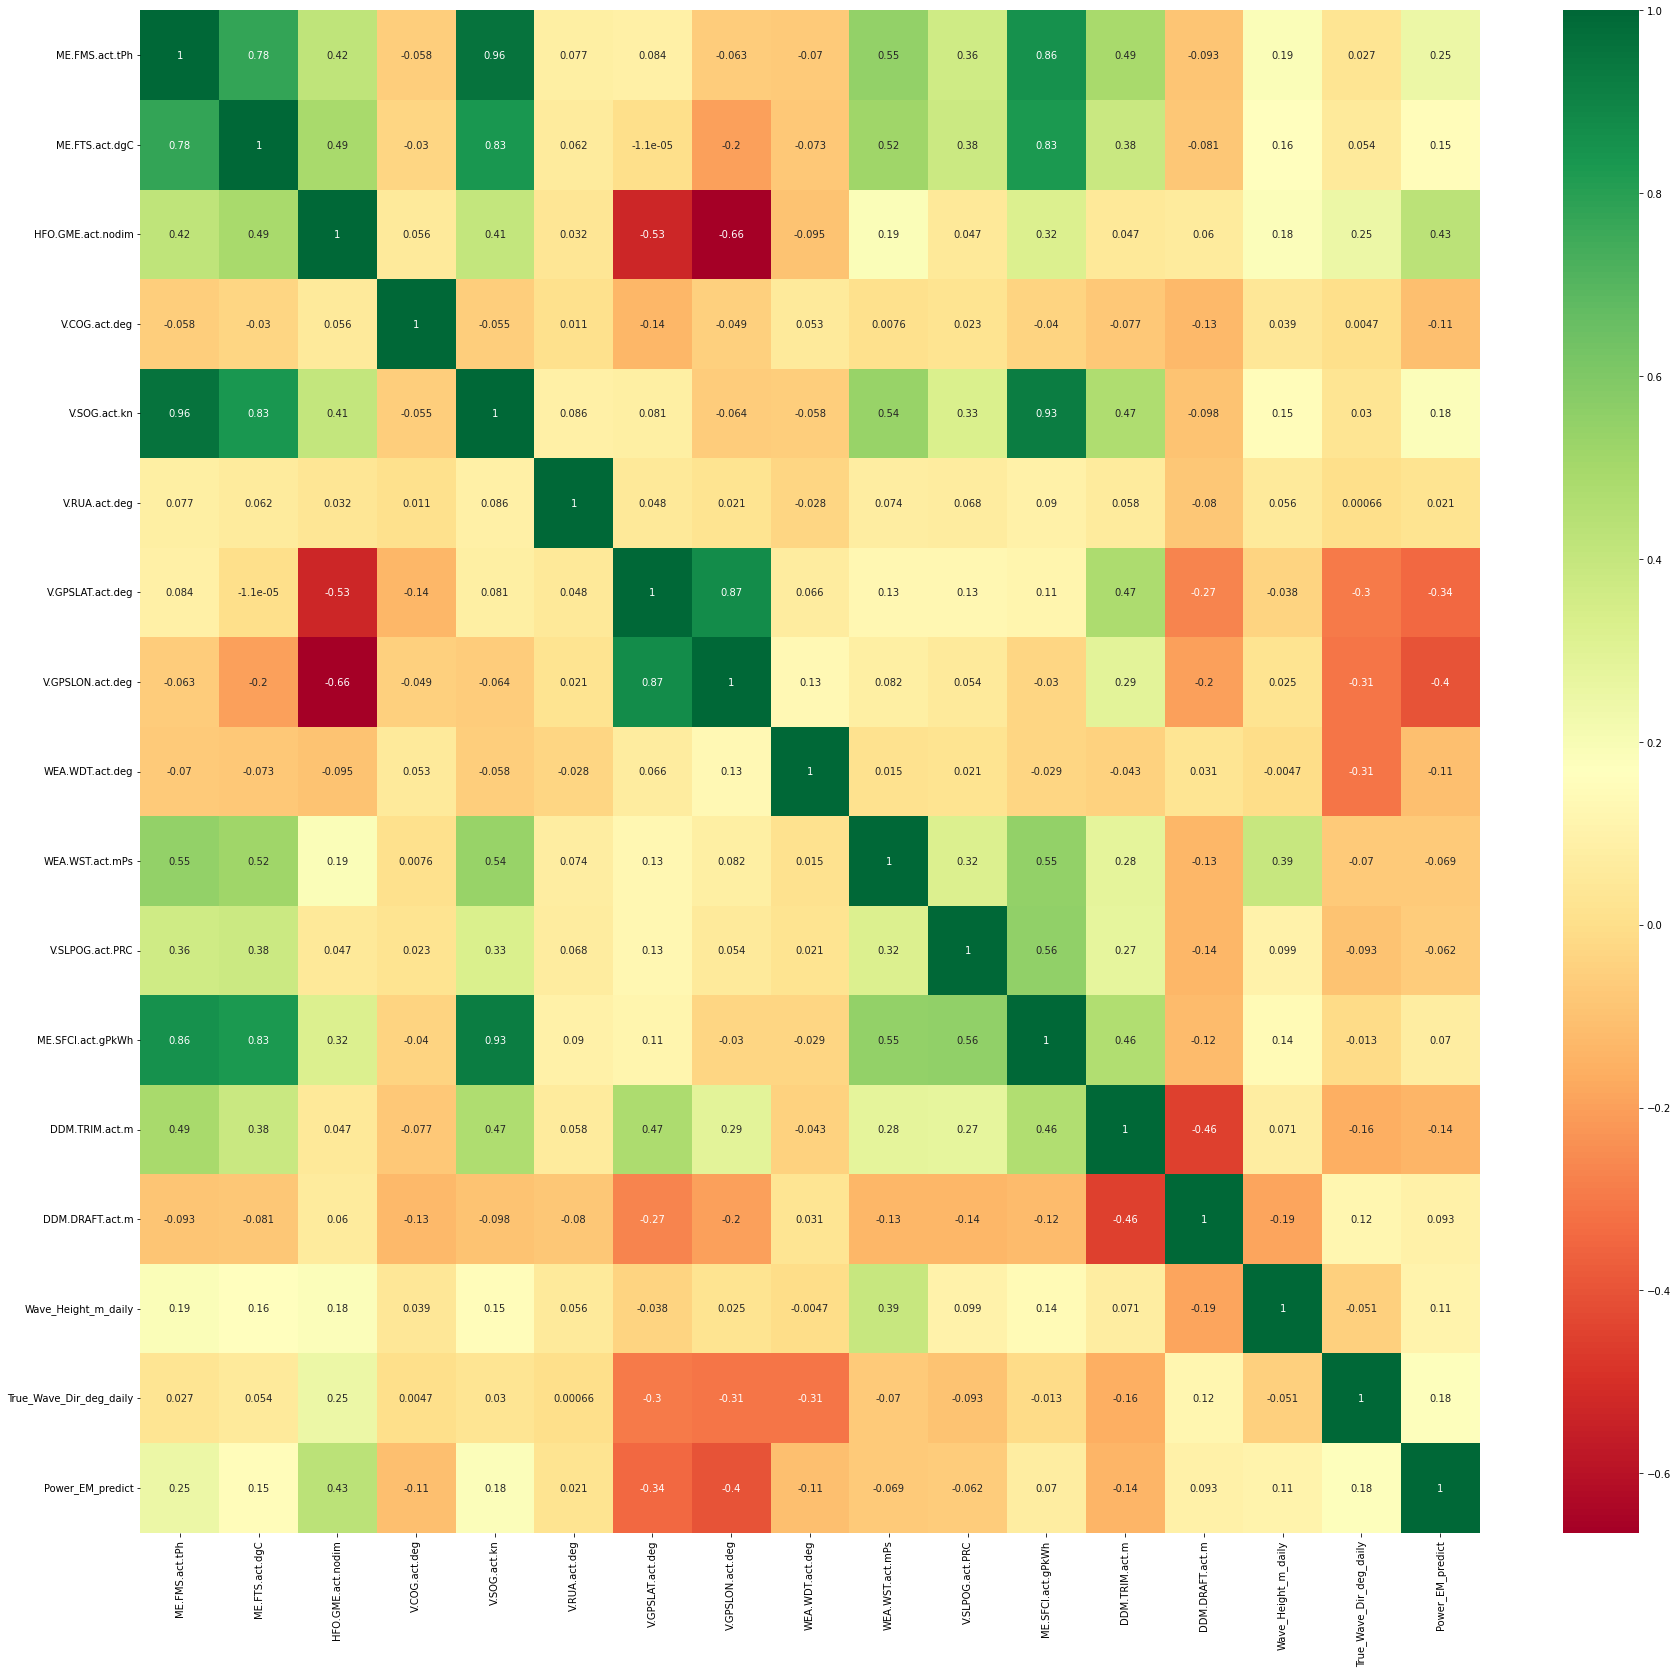

In [10]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

### Define Target

In [11]:
df_model = df_model[df_model['ME.FMS.act.tPh'] < 8]
df_model.shape

(180148, 18)

In [12]:
df_model = df_model[df_model['V.SOG.act.kn'] > 13.5]
df_model.shape

(101065, 18)

In [13]:
X = df_model.drop(['ME.FMS.act.tPh', 'Power_EM_predict', 'ME.SFCI.act.gPkWh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

### Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.2, random_state = 42)

### Create dummy values for feature 'passage_type'

In [15]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80852 entries, 125041 to 80691
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ME.FTS.act.dgC                    80852 non-null  float64
 1   HFO.GME.act.nodim                 80852 non-null  float64
 2   V.COG.act.deg                     80852 non-null  float64
 3   V.SOG.act.kn                      80852 non-null  float64
 4   V.RUA.act.deg                     80852 non-null  float64
 5   V.GPSLAT.act.deg                  80852 non-null  float64
 6   V.GPSLON.act.deg                  80852 non-null  float64
 7   WEA.WDT.act.deg                   80852 non-null  float64
 8   WEA.WST.act.mPs                   80852 non-null  float64
 9   V.SLPOG.act.PRC                   80852 non-null  float64
 10  DDM.TRIM.act.m                    80852 non-null  float64
 11  DDM.DRAFT.act.m                   80852 non-null  float64
 12 

### Set MLFlow connection

In [17]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name='LinReg_with_PolyFeatures_no_EM_SFCI_>13.5kn') # CHANGE!
run = mlflow.active_run()

## Modelling

In [18]:
reg = make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler() , LinearRegression()) # CHANGE!

In [19]:
reg.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [20]:
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

In [21]:
y_pred[y_pred < 0] = 0
y_pred_train[y_pred_train < 0] = 0

## Analysis

In [22]:
print('RMSE train: ', mean_squared_error(y_train, y_pred_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred, squared= False))
rmse_test = mean_squared_error(y_test, y_pred, squared= False)

RMSE train:  0.11501049184277977
RMSE test:  0.11438613443993678


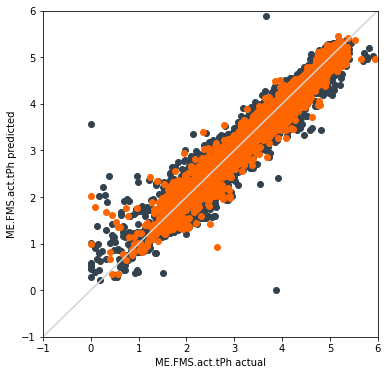

In [23]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred_train, color ='#33424F')
plt.scatter(y_test, y_pred, color = '#FF6600')
#plt.xticks(np.arange(0,501,100));
#plt.yticks(np.arange(0,501,100));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");
plt.xlim(-1, 6);
plt.ylim(-1, 6);

### Write to MLFlow

In [24]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'according to Capstone_features_Features.csv + t/h kleiner 8 + EM and SCFI drop + Speed > 13.5 kn',
      "explanation": 'Linear Regression with Polynomial features of degree 2 and all negative Prediction set to 0',
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler',
      'Polynomialdegree' : 2,
      'size_test' : 0.2
  }

In [25]:
#logging params to mlflow
mlflow.log_params(params)
#setting tags
mlflow.set_tag("running_from_jupyter", "True")
#logging metrics
mlflow.log_metric("train-" + "RMSE", rmse_train)
mlflow.log_metric("test-" + "RMSE", rmse_test)
# logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# but possible if running mlflow locally
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

### What are the most important features?

In [26]:
X_train.columns

Index(['ME.FTS.act.dgC', 'HFO.GME.act.nodim', 'V.COG.act.deg', 'V.SOG.act.kn',
       'V.RUA.act.deg', 'V.GPSLAT.act.deg', 'V.GPSLON.act.deg',
       'WEA.WDT.act.deg', 'WEA.WST.act.mPs', 'V.SLPOG.act.PRC',
       'DDM.TRIM.act.m', 'DDM.DRAFT.act.m', 'Wave_Height_m_daily',
       'True_Wave_Dir_deg_daily', 'passage_type_Europe>13.5kn',
       'passage_type_SouthAmerica>13.5kn'],
      dtype='object')

In [27]:
print('Nr. of input features: ', reg.steps[0][1].n_features_in_)
print('Nr. of output features: ', reg.steps[0][1].n_output_features_)

Nr. of input features:  16
Nr. of output features:  153


In [28]:
reg.steps[0][1].get_feature_names_out()

array(['1', 'ME.FTS.act.dgC', 'HFO.GME.act.nodim', 'V.COG.act.deg',
       'V.SOG.act.kn', 'V.RUA.act.deg', 'V.GPSLAT.act.deg',
       'V.GPSLON.act.deg', 'WEA.WDT.act.deg', 'WEA.WST.act.mPs',
       'V.SLPOG.act.PRC', 'DDM.TRIM.act.m', 'DDM.DRAFT.act.m',
       'Wave_Height_m_daily', 'True_Wave_Dir_deg_daily',
       'passage_type_Europe>13.5kn', 'passage_type_SouthAmerica>13.5kn',
       'ME.FTS.act.dgC^2', 'ME.FTS.act.dgC HFO.GME.act.nodim',
       'ME.FTS.act.dgC V.COG.act.deg', 'ME.FTS.act.dgC V.SOG.act.kn',
       'ME.FTS.act.dgC V.RUA.act.deg', 'ME.FTS.act.dgC V.GPSLAT.act.deg',
       'ME.FTS.act.dgC V.GPSLON.act.deg',
       'ME.FTS.act.dgC WEA.WDT.act.deg', 'ME.FTS.act.dgC WEA.WST.act.mPs',
       'ME.FTS.act.dgC V.SLPOG.act.PRC', 'ME.FTS.act.dgC DDM.TRIM.act.m',
       'ME.FTS.act.dgC DDM.DRAFT.act.m',
       'ME.FTS.act.dgC Wave_Height_m_daily',
       'ME.FTS.act.dgC True_Wave_Dir_deg_daily',
       'ME.FTS.act.dgC passage_type_Europe>13.5kn',
       'ME.FTS.act.dgC passag

In [29]:
reg.steps[2][1].coef_

array([ 9.93313267e-16,  1.93416287e+00, -3.58105741e-01,  8.89755519e-01,
       -3.06489994e+00,  2.12233044e+00, -5.33055970e+00, -3.99271124e+00,
        7.27375317e-01,  9.03829697e-02, -9.79668161e+00, -8.10685880e+00,
       -1.56997601e+00, -1.55222972e+00, -8.79927056e-01, -1.71058353e+00,
       -4.42541397e+00, -2.48399741e+00, -2.67456276e-01,  4.87415234e-01,
       -2.42992180e-01,  1.76837529e+00, -8.18308047e-01, -9.73193469e-01,
       -1.11396495e+00,  1.88604818e+00,  2.77076117e+00,  3.56089667e+00,
       -6.09308565e-02,  3.77420411e-01,  6.00402689e-01, -2.27169058e-01,
        1.87020909e-01, -3.58105741e-01, -8.65623171e-02, -1.28598149e+00,
       -1.11086597e+00,  3.47181075e+00,  4.33561935e-01,  2.97160350e-01,
       -2.72070729e-01, -3.24444807e-01,  4.31914660e-01, -1.13315528e-01,
       -4.44357702e-01, -1.30515633e-02,  3.63042929e-14,  1.96474937e+00,
       -5.03764528e-01, -3.93126143e-01, -3.66556937e-01, -5.60817237e-01,
        8.50048255e-01,  

In [30]:
df_coef = pd.DataFrame({'features' : reg.steps[0][1].get_feature_names_out(), 'coef' : reg.steps[2][1].coef_})
df_coef.sort_values('coef')

,features,coef
10,V.SLPOG.act.PRC,-9.796682
11,DDM.TRIM.act.m,-8.106859
107,V.GPSLON.act.deg passage_type_SouthAmerica>13.5kn,-5.890748
6,V.GPSLAT.act.deg,-5.330560
152,passage_type_SouthAmerica>13.5kn^2,-4.425414
...,...,...
97,V.GPSLAT.act.deg passage_type_SouthAmerica>13.5kn,3.673905
69,V.SOG.act.kn DDM.TRIM.act.m,3.904885
96,V.GPSLAT.act.deg passage_type_Europe>13.5kn,5.643671
62,V.SOG.act.kn^2,9.316636


In [31]:
df_coef.sort_values('coef').head(20)

,features,coef
10,V.SLPOG.act.PRC,-9.796682
11,DDM.TRIM.act.m,-8.106859
107,V.GPSLON.act.deg passage_type_SouthAmerica>13.5kn,-5.890748
6,V.GPSLAT.act.deg,-5.330560
152,passage_type_SouthAmerica>13.5kn^2,-4.425414
16,passage_type_SouthAmerica>13.5kn,-4.425414
7,V.GPSLON.act.deg,-3.992711
98,V.GPSLON.act.deg^2,-3.436964
64,V.SOG.act.kn V.GPSLAT.act.deg,-3.065370
4,V.SOG.act.kn,-3.064900


## Error Analysis

In [32]:
from yellowbrick.regressor import ResidualsPlot

/Users/patrickk/neuefische/capstone_ml_shipping/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


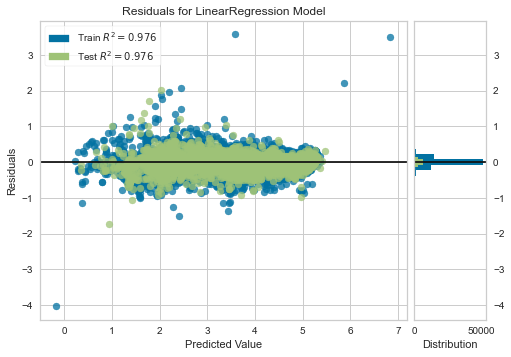

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [33]:
visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

In [34]:
residuals_test = y_pred - y_test
residuals_train = y_pred_train - y_train

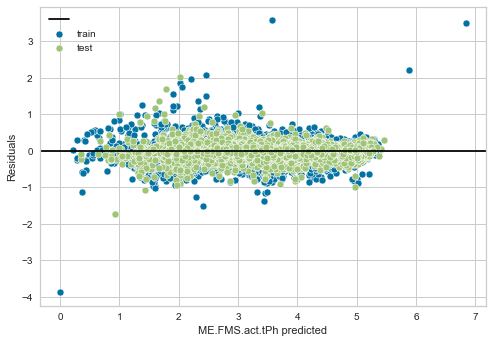

In [35]:
sns.scatterplot(x = y_pred_train, y = residuals_train)
sns.scatterplot(x = y_pred, y = residuals_test)
plt.axhline(y = 0, color = 'black')
plt.xlabel("ME.FMS.act.tPh predicted");
plt.ylabel("Residuals");
plt.legend(labels=['', 'train', 'test'])

## Understanding what happens when the t/h is 0 but values are getting predicted

In [36]:
X_train_actzeros = X_train.copy()
X_train_actzeros['actual'] = y_train
X_train_actzeros['predict'] = y_pred_train

In [37]:
X_train_actzeros = X_train_actzeros[X_train_actzeros['actual'] == 0]
X_train_actzeros = X_train_actzeros[X_train_actzeros['predict'] > 0.1]
X_train_actzeros

,ME.FTS.act.dgC,HFO.GME.act.nodim,V.COG.act.deg,V.SOG.act.kn,V.RUA.act.deg,V.GPSLAT.act.deg,V.GPSLON.act.deg,WEA.WDT.act.deg,WEA.WST.act.mPs,V.SLPOG.act.PRC,DDM.TRIM.act.m,DDM.DRAFT.act.m,Wave_Height_m_daily,True_Wave_Dir_deg_daily,passage_type_Europe>13.5kn,passage_type_SouthAmerica>13.5kn,actual,predict
185294,64.161621,0.0,81.800003,15.515,5.3,51.417149,3.495315,19.060120,11.046195,-38.684681,0.9960,-0.1164,0.2,109.0,1,0,0.0,0.290692
29492,77.086243,1.0,227.300003,18.368,1.6,25.041651,-60.771141,98.935608,6.801482,8.165892,1.5514,-0.0193,1.0,187.0,0,0,0.0,3.572080
180037,64.011566,0.0,25.000000,13.900,-13.3,51.828247,1.565171,65.450356,6.185137,-45.913124,1.0220,0.0341,1.5,279.0,1,0,0.0,0.582955
94524,58.627563,0.0,283.100006,13.518,11.8,53.994736,8.317142,181.384155,13.720582,-30.187052,1.5672,-4.4470,3.5,29.0,1,0,0.0,0.553087
66034,63.281647,0.0,323.600006,13.719,1.2,8.769071,-79.428337,281.225464,4.945259,-1.625358,0.4230,-0.0436,0.2,99.0,0,1,0.0,1.013363
61846,70.470398,1.0,31.299999,14.286,0.5,-2.952412,-80.531250,231.296967,8.765638,-18.084476,-0.1276,-0.2500,0.5,69.0,0,1,0.0,0.518651
151470,71.846619,1.0,47.599998,13.806,-10.4,-2.786318,-80.255806,272.338776,4.740757,-44.068378,-0.8110,-0.0068,2.0,19.0,0,1,0.0,0.447929


In [38]:
import plotly.express as px

In [39]:
px.scatter(X_train_actzeros, x='V.SOG.act.kn',
            y='predict',
            color='predict',
            hover_data=['V.RUA.act.deg'],
            labels={'x':'V.SOG.act.kn','y':'predict','color':'V.RUA.act.deg'})

In [40]:
px.scatter(X_train_actzeros, x='V.SLPOG.act.PRC',
            y='predict',
            color='predict',
            hover_data=['V.RUA.act.deg'],
            labels={'x':'V.SOG.act.kn','y':'predict','color':'V.RUA.act.deg'})

In [41]:
X_train_actzeros.columns

Index(['ME.FTS.act.dgC', 'HFO.GME.act.nodim', 'V.COG.act.deg', 'V.SOG.act.kn',
       'V.RUA.act.deg', 'V.GPSLAT.act.deg', 'V.GPSLON.act.deg',
       'WEA.WDT.act.deg', 'WEA.WST.act.mPs', 'V.SLPOG.act.PRC',
       'DDM.TRIM.act.m', 'DDM.DRAFT.act.m', 'Wave_Height_m_daily',
       'True_Wave_Dir_deg_daily', 'passage_type_Europe>13.5kn',
       'passage_type_SouthAmerica>13.5kn', 'actual', 'predict'],
      dtype='object')

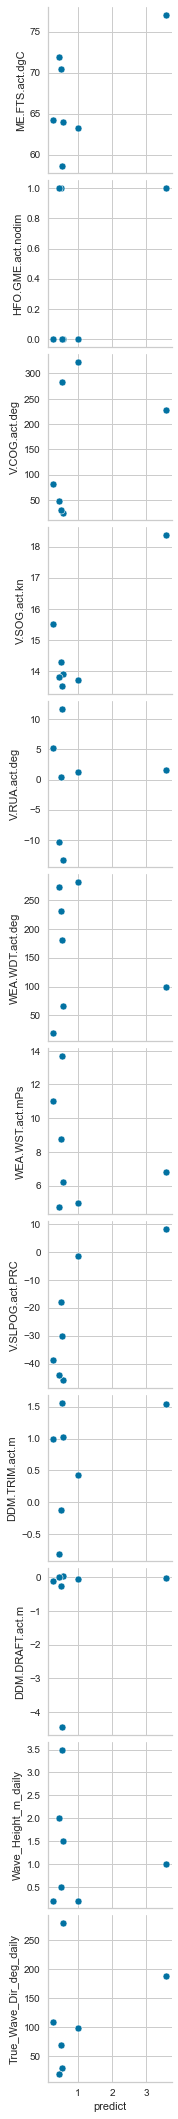

In [42]:
sns.pairplot(data=X_train_actzeros,
                  x_vars=['predict'],
                  y_vars=['ME.FTS.act.dgC', 'HFO.GME.act.nodim', 'V.COG.act.deg', 'V.SOG.act.kn',
       'V.RUA.act.deg','WEA.WDT.act.deg', 'WEA.WST.act.mPs', 'V.SLPOG.act.PRC',
        'DDM.TRIM.act.m', 'DDM.DRAFT.act.m',
       'Wave_Height_m_daily', 'True_Wave_Dir_deg_daily'])

## Understanding what happens when the residuals are bigger than 

In [43]:
X_train_res = X_train.copy()
X_train_res['actual'] = y_train
X_train_res['predict'] = y_pred_train
X_train_res['residuals'] = residuals_train
X_train_res.head()

,ME.FTS.act.dgC,HFO.GME.act.nodim,V.COG.act.deg,V.SOG.act.kn,V.RUA.act.deg,V.GPSLAT.act.deg,V.GPSLON.act.deg,WEA.WDT.act.deg,WEA.WST.act.mPs,V.SLPOG.act.PRC,DDM.TRIM.act.m,DDM.DRAFT.act.m,Wave_Height_m_daily,True_Wave_Dir_deg_daily,passage_type_Europe>13.5kn,passage_type_SouthAmerica>13.5kn,actual,predict,residuals
125041,72.960907,1.0,231.100006,16.493999,-1.4,3.078413,-78.219391,283.961182,9.548179,9.162142,0.6780,-0.0530,1.0,9.0,0,1,2.826419,2.854786,0.028367
150425,74.222260,1.0,324.799988,20.767000,0.4,-7.466093,-80.456139,139.557678,4.445702,2.856872,-0.3446,-0.0156,2.0,349.0,0,1,4.237973,4.366254,0.128281
76412,69.997925,1.0,45.200001,19.313000,-2.4,22.248396,-64.376839,96.974754,9.281954,6.640728,2.2520,0.0259,1.5,259.0,0,0,4.269421,4.216493,-0.052928
50197,73.708984,1.0,325.600006,17.613001,1.2,-22.008074,-71.141800,190.271545,6.308152,3.859242,-0.2406,-0.1348,1.0,329.0,0,1,2.931184,2.687166,-0.244018
46992,69.890289,1.0,162.399994,16.945000,0.3,-12.888535,-77.041855,119.915070,5.312985,9.662910,-0.1798,0.2261,0.1,339.0,0,1,3.042964,3.034317,-0.008648


In [44]:
X_train_res = X_train_res[(X_train_res['residuals'] > 1) | (X_train_res['residuals'] <  -1)]

In [45]:
px.scatter(X_train_res, x='actual',
            y='predict',
            color='V.SOG.act.kn',
            hover_data=['V.RUA.act.deg'],
            labels={'x':'V.SOG.act.kn','y':'predict','color':'V.RUA.act.deg'})

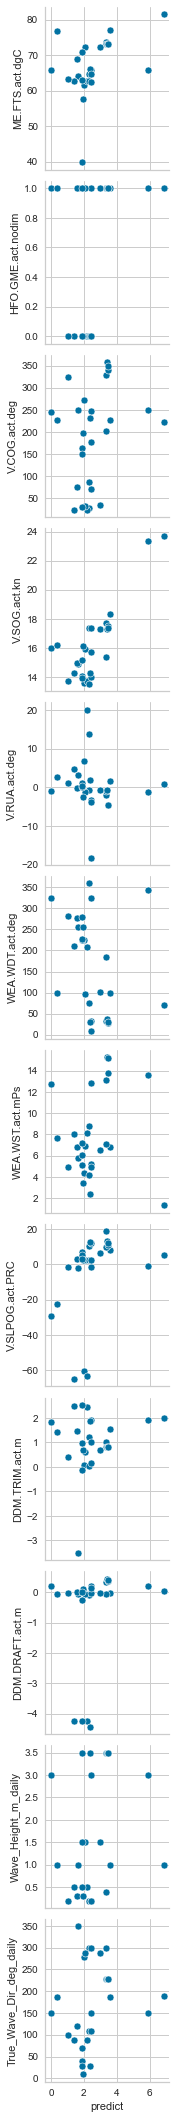

In [46]:
sns.pairplot(data=X_train_res,
                  x_vars=['predict'],
                  y_vars=['ME.FTS.act.dgC', 'HFO.GME.act.nodim', 'V.COG.act.deg', 'V.SOG.act.kn',
       'V.RUA.act.deg','WEA.WDT.act.deg', 'WEA.WST.act.mPs', 'V.SLPOG.act.PRC',
        'DDM.TRIM.act.m', 'DDM.DRAFT.act.m',
       'Wave_Height_m_daily', 'True_Wave_Dir_deg_daily'])